# Pruebas de estrés desde la perspectiva de los sistemas lineales e invariantes en el tiempo


[Juan M. Fonseca-Solís](https://juanfonsecasolis.github.io/) · Agosto 2020 · 5 min read

---

## Resumen

Las pruebas de rendimiento de software son útiles para determinar si un sistema es capaz de procesar suficientes cantidades de información sin caerse o realentizarse. Ejemplos de sistemas que requieren hacer este tipo de pruebas son las páginas web de los bancos o de los sitios de comercio electrónico, donde un retraso en el despliegue de la información puede traducirse en pérdida de clientes. En este ipython notebook estudiamos un tipo de prueba de rendimiento llamada "pruebas de estrés" que tiene como objetivo encontrar el punto de quiebre, es decir, el máximo número de transacciones por segundo que el sistema es capaz de procesar antes de caerse. A diferencia del resto de artículos que explican cómo realizar estas pruebas con las herramientas de software existentes, nuestro enfoque se dedica a la parte del modelado matemático para la estimación de la respuesta ante señales tipo rampa. Los resultados obtenidos permitieron determinar que el sistema no es lineal e invariante en el tiempo, y que por lo tanto, calcular su respuesta al impulso no permite simular la salida.

# 1 Pruebas de estrés

Una prueba de estrés tiene como objetivo encontrar el punto de quiebre, es decir, el maximo número de transacciones por segundo que el sistema es capaz de procesar antes de caerse [1]. Para encontrar este valor se utiliza un enfoque iterativo que realiza incrementos lineales en el número del número de transacciones por segundo mientras se monitorean otras señales como el número de errores por segundo y los tiempos de respuesta. El número de transacciones por segundo también es llamado _usuarios virtuales_ por segundo (o VU/s, por sus siglas en inglés) y gráficamente se ve así:

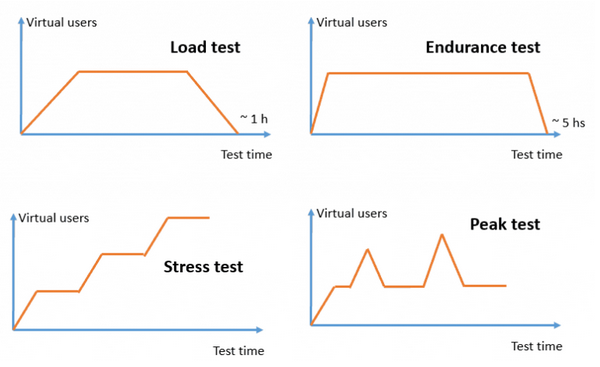

Figura 1. Imágen tomada sin permiso de https://abstracta.us/wp-content/uploads/2015/10/why-perf-testing-is-nec-chart-768x463.png.

A modo de una simplificación, esta forma escalonada de la función de usuarios virtuales por segundo puede representarse como una rampa modelada con la ecuación $x[n]= \frac{dx}{n} n u[n]$, donde $0<\frac{dx}{n}$ es la tasa de cambio (VU por segundo) y $u[n]$ es la función de Heaviside o escalón unitario (1 cuando $0 \le n$, 0 en el resto):

Populating the interactive namespace from numpy and matplotlib


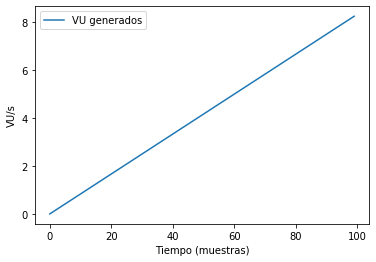

In [2]:
%pylab inline
import numpy as np

pylab.plot(5/60*np.arange(0,100),label='VU generados')
pylab.xlabel('Tiempo (muestras)')
pylab.ylabel('VU/s')
pylab.legend()

La función de usuarios virtuales por segundo se relaciona con una curva llamada _ancho de banda del sistema_ (_throughput_, en Inglés), que representa la capacidad del sistema a través del tiempo. Esta curva es linealmente creciente en los primeros instantes (pues entre más se le exige al sistema más capacidad mostrará), y luego se comporta de forma constante, cuando llega al punto de quiebre. Para modelarla, podemos tomar la rampa definida anteriormente y definirla como sigue:

$$
x[n] = \frac{q}{n_0} n u[n],
$$

y luego definir la respuesta del sistema a la rampa:

$$
y[n] = \min(x[n], q),\qquad(1)
$$

donde $0<q$ es el punto de quiebre y $n_0$ el instante donde ocurre. Tomando $q=5$ y $n_0=60$ podemos ver un ejemplo:

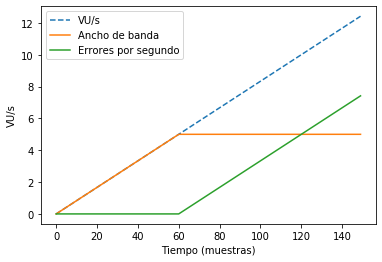

In [17]:
N = 150 # duracion del experimento (en numero de muestras)
n0 = 60 # instante del punto de quiebre (en numero de muestras)
q = 5.0 # punto de quiebre (en usuarios virtuales por segundo)1
n = np.arange(0,N)
x = q/n0 * n

def respuestaRampa(x):
    N = len(x)
    y = np.zeros(N)
    for n in range(1,N):
        y[n] = np.min([x[n], q])
    return y

y = respuestaRampa(x)
pylab.plot(x,'--',label='VU/s')
pylab.plot(y,label='Ancho de banda')
pylab.plot(x-y,label='Errores por segundo')
pylab.xlabel('Tiempo (muestras)')
pylab.ylabel('VU/s')
pylab.legend()

Se observa que después de haber transcurrido $n_0$ muestras, la respuesta del sistema se aplana como es deseado, y la cantidad de errores aumenta proporcionalmente al número de transacciones no procesadas. Este número de errores es también otra medida de interés y se calcula como la diferencia entre el número de usuarios por muestra generados y el ancho de banda del sistema: $e[n] = x[n] - y[n]$, y a nivel del protocolo _hyper text transfer protocol_ (HTTP, por sus siglas en Inglés) se traduce en errores del tipo 500. 

Las pruebas de estrés consisten en encontrar estas dos métricas que hemos mencionado hasta ahora (ancho de banda y errores por segundo) junto con otra más llamada la _curva de retrasos_. Otro tipo de prueba de estrés es "quitarle" al servidor recursos de memoria, capacidad de procesamiento o ancho de banda; esto sirve por ejemplo para simular el caso en el que un balanceador de carga cuenta con menos servidores [8]. 

# 2 Probando un sitio web

Teniendo una idea de qué es una prueba de estrés, podemos estudiar el comportamiento de un sistema real con un ejemplo. Para ello procedemos a estresar una página web dedicada a la visualización de datos de la presión sanguínea (https://bloodpressurepulse.herokuapp.com/xxyn4pz8yhb0i7n). Este sitio consume archivos CSV almacenados en la nube para generar gráficos interactivos usando Python (Dash). Un vistazo de la interfaz principal se observa en la figura 2.

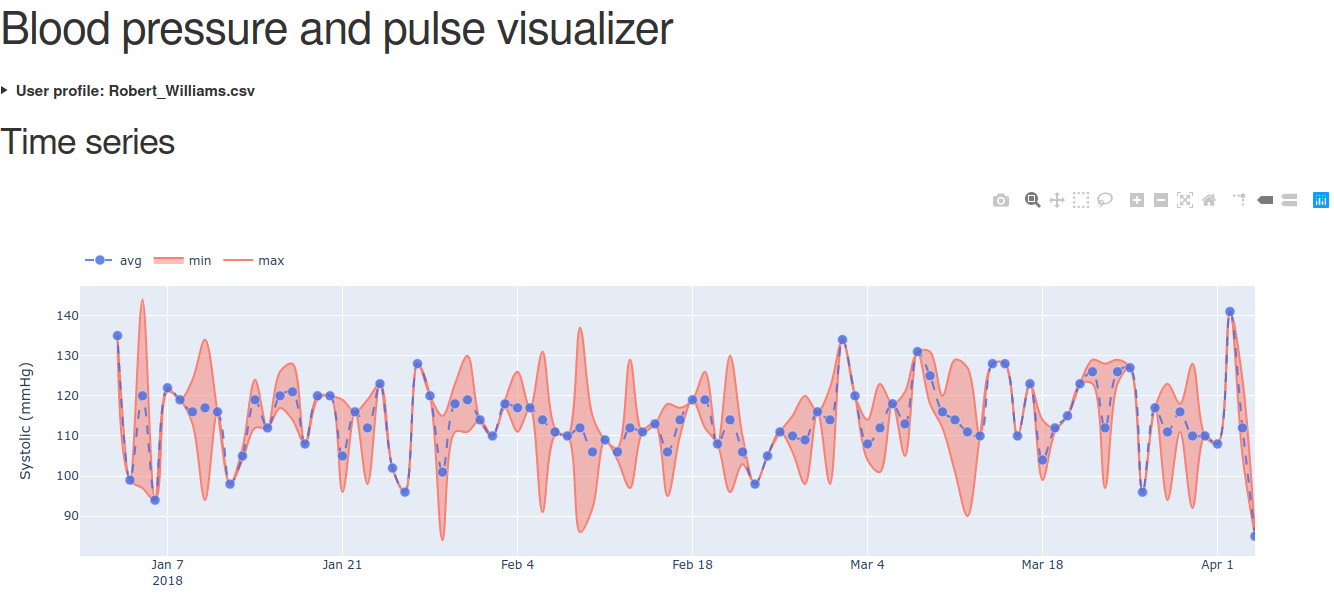
Figura 2. Pantallazo del sitio web.

Hay dos formas de estresar esta página, una sería hacer que el sistema procese archivos CSV cada vez más grandes, y la otra, sería simular una carga incremental de usuarios como se estudió en la sección 1. Vamos a proceder con la segunda opción. Para ello, elegimos el software JMeter de código libre y amplio uso en la industria. Elegimos este software y no otros, como Blaze Meter o Load Ninja, porque es gratuito. El código de JMeter para la prueba se encuentra en el sitio [https://github.com/juanfonsecasolis](https://github.com/juanfonsecasolis) y los parámetros elegido son los siguientes:
* **Tiempo de rampa (TR):** 60 segundos.
* **Total de usuarios:** 30 (i.e., el acumulado de usuarios $\int_0^{\text{TR}}{x dx}$).

Las figuras 3-5 muestran los resultados obtenidos.

![](rampa/bytesThroughputOverTime.png)
Figura 3. Ancho de banda para una señal de entrada en forma de rampa.

![](rampa/responseTimesOverTime.png)
Figura 4. Tiempos de respuesta para una señal de entrada en forma de rampa.

![](rampa/resultsInTable.png)
Figura 5. Solicitudes exitosas vs. fallidas para una señal de entrada en forma de rampa.

La figura 3 muestra que, salvo algunos picos aislados, la forma obtenido del ancho de banda se asemeja a la de nuestro modelado de la sección 1, y que los tiempos de respuesta obedecen a un comportamiento casi exponencial. La figura 5 muestra también que el punto de quiebre se alcanzó a los 10 VU/s. 

# 3 ¿Son los servidores web sistemas LTI?

En este punto, podemos decir que la ecuación 1 nos permite representar el comportamiento esperado en una prueba de estrés cuando la entrada es una rampa. Sin embargo, sería deseable poder modelar el comportamiento del sistema cuando se somete a otras entradas, como por ejemplo a cargas en forma trapezoidal como las de la figura 1. Para ello podríamos considerar usar la teoría de los sistemas lineales e invariantes en el tiempo (LTI, por sus siglas en Inglés) que dice que es posible caracterizar completamente el comportamiento de un sistema midiendo su respuesta al impulso. Para determinar si un sistema es LTI se debe comprobar que cumple con las siguientes dos condiciones [3]:
1. Cumplir con el principio de superposición: $T(\alpha{x_1}+\beta{x_2}) = \alpha{T(x_1)}+\beta{T(x_2)}$ (escalamiento y aditividad).
2. Ser invariante en el tiempo.

En nuestro afán de determinar si un servidor web es un sistema es LTI podemos ver que el sistema no cumple la propiedad de aditividad porque con $\alpha=\beta=1$ y haciendo $x_1[n]=x_2[n]=q$ tenemos que:

$$
T(x_1[n]+x_2[n]) = \min(x_1[n]+x_2[n], q) = \min(2q,q) = q,
$$

$$
T(x_1[n])+T(x_2[n]) = \min(x_1[n], q) + \min(x_2[n], q) = \min(q,q) + \min(q, q) = 2q,
$$

donde se observa que $T(x_1[n]+x_2[n]) \neq T(x_1[n])+T(x_2[n])$, por lo tanto el sistema no es LTI.

Es importante destacar que el tipo de modelo afecta la calidad de las estimaciones, porque también pudimos haber sustituido la ecuación 1 por $y[n] = x[n] - x[n-n_0]$ y haber obtenido la misma curva, pero donde el sistema sí sería LTI (la salida sería proporcional a la entrada) y no acorde a la realidad. Acá lo podemos observar:

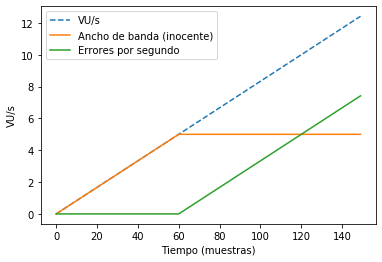

In [18]:
def respuestaRampaInocente(x, n0):
    N = len(x)
    y = np.zeros(N)
    for n in range(1,N):
        y[n] = x[n] - (x[n-n0] if 0<=n-n0 else 0)
    return y

y = respuestaRampaInocente(x,n0)
pylab.plot(x,'--',label='VU/s')
pylab.plot(y,label='Ancho de banda (inocente)')
pylab.plot(x-y,label='Errores por segundo')
pylab.xlabel('Tiempo (muestras)')
pylab.ylabel('VU/s')
pylab.legend()

Aca el haber procesado la entrada $x[n] =  2 \frac{q}{n_0} n u(n)$ habría duplicado la capacidad del sistema, lo cual es irrealista:

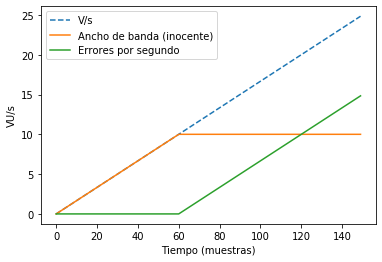

In [21]:
y = respuestaRampaInocente(2*x,n0)
pylab.plot(2*x,'--',label='V/s')
pylab.plot(y,label='Ancho de banda (inocente)')
pylab.plot(2*x-y,label='Errores por segundo')
pylab.xlabel('Tiempo (muestras)')
pylab.ylabel('VU/s')
pylab.legend()

Se entiende entonces que es necesario acudir a técnicas de modelado no lineal para estimar la respuesta ante otro tipo de entradas [6,7].

# Conclusiones

Se encontraron dos modelos para simular el comportamiento del sistema antes una prueba de estrés mediante una entrada tipo rampa. Solo uno de los modelos logró respetar la característica no lineal e invariante en el tiempo del sistema real. Esto significa que en un servidor web los recursos son limitados y que la salida no es proporcional a la entrada, por lo tanto su comportamiento no puede modelarse mediante una respuesta al impulso.

# Referencias
1. Pruebas de rendimiento del software. (2020, 11 de abril). Wikipedia, La enciclopedia libre. Fecha de consulta: 01:24, agosto 23, 2020 desde https://es.wikipedia.org/w/index.php?title=Pruebas_de_rendimiento_del_software&oldid=125096412. 
2. JMeter. (2020, 9 de enero). Wikipedia, La enciclopedia libre. Fecha de consulta: 02:28, agosto 23, 2020 desde https://es.wikipedia.org/w/index.php?title=JMeter&oldid=122610309.
3. Delta de Dirac. (2020, 10 de junio). Wikipedia, La enciclopedia libre. Fecha de consulta: 22:56, agosto 23, 2020 desde https://es.wikipedia.org/w/index.php?title=Delta_de_Dirac&oldid=126816207. 
4. Convolución. (2020, 24 de mayo). Wikipedia, La enciclopedia libre. Fecha de consulta: 01:36, agosto 24, 2020 desde https://es.wikipedia.org/w/index.php?title=Convoluci%C3%B3n&oldid=126349064. 
5. Respuesta a impulso. (2020, 12 de enero). Wikipedia, La enciclopedia libre. Fecha de consulta: 02:45, agosto 24, 2020 desde https://es.wikipedia.org/w/index.php?title=Respuesta_a_impulso&oldid=122700886. 
6. Sistema no lineal. (2020, 13 de abril). Wikipedia, La enciclopedia libre. Fecha de consulta: 04:02, agosto 28, 2020 desde https://es.wikipedia.org/w/index.php?title=Sistema_no_lineal&oldid=125141877. 
7. Wikipedia contributors. (2020, February 21). Non-linear multi-dimensional signal processing. In Wikipedia, The Free Encyclopedia. Retrieved 04:02, August 28, 2020, from https://en.wikipedia.org/w/index.php?title=Non-linear_multi-dimensional_signal_processing&oldid=941976954 
8. Balance de carga. (2020, 5 de mayo). Wikipedia, La enciclopedia libre. Fecha de consulta: 21:42, agosto 29, 2020 desde https://es.wikipedia.org/w/index.php?title=Balance_de_carga&oldid=125804878. 

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>.